In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Read CSV File

In [182]:
df = pd.read_csv('data.csv')

# DataFrame to np.array

In [183]:
features = df.drop(['J1', 'J2', 'J3'], axis=1)
features = np.array(features)
target_value = df['J3']
target_value = np.array(target_value)
min_j3 = np.min(target_value)
max_j3 = np.max(target_value)
print(f'target_min : {min_j3} and target_max : {max_j3}')

target_min : 17.20599999999999 and target_max : 24.561000000000007


In [184]:
df['J4'] = np.where(df['J3'] > 22.5, 1, 0)  # 1 means Positive and 0 means Negative
target = target_value
count_j4 = df['J4'].value_counts()
print(f'Positive target count : {count_j4[1]} and Negative target count : {count_j4[0]}')

Positive target count : 2034 and Negative target count : 97966


# Train,Test,Split

In [185]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Decision Tree

In [186]:
DT_model = tree.DecisionTreeRegressor(max_depth=20,random_state=42)
DT_model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=20, random_state=42)

#### Predictions

In [187]:
y_pred = DT_model.predict(x_test)
result_df = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})

In [188]:
result_df['y_pred_class'] = np.where(result_df['y_pred'] > 22.5, 1, 0)  # 1 means Positive and 0 means Negative
result_df['y_test_class'] = np.where(result_df['y_test'] > 22.5, 1, 0)  # 1 means Positive and 0 means Negative
y_pred_class_count = result_df['y_pred_class'].value_counts()
y_test_class_count = result_df['y_test_class'].value_counts()
print(f'Positive target count : {y_pred_class_count[1]} and Negative target count : {y_pred_class_count[0]}')
print(f'Positive target count : {y_test_class_count[1]} and Negative target count : {y_test_class_count[0]}')

Positive target count : 358 and Negative target count : 19642
Positive target count : 398 and Negative target count : 19602


## Confusion Matrix

In [189]:
def my_confusion_matrix(y_test_class_items, y_pred_class_items):
    my_tp = np.sum((y_test_class_items == 1) & (y_pred_class_items == 1))
    mt_tn = np.sum((y_test_class_items == 0) & (y_pred_class_items == 0))
    my_fp = np.sum((y_test_class_items == 0) & (y_pred_class_items == 1))
    my_fn = np.sum((y_test_class_items == 1) & (y_pred_class_items == 0))
    return my_tp, mt_tn, my_fp, my_fn

In [190]:
y_pred_class=result_df['y_pred_class']
y_test_class=result_df['y_test_class']
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
tp = conf_matrix[1, 1]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
tn = conf_matrix[0, 0]
print(f'By SKLearn  : TN :{tn} , FP : {fp} , TP : {tp} , FN : {fn}')

TP, TN, FP, FN = my_confusion_matrix(result_df['y_test_class'].values, result_df['y_pred_class'].values)
print(f'By Function : TN :{TN} , FP : {FP} , TP : {TP} , FN : {FN}')

total = TN + TP + FN + FP
positives = TP + FN
negatives = TN + FP
sensitivity = TP / positives  # its recall
specificity = TN / negatives
precision = TP/(TP+FP)
# precision میگه از تعدادی که من مثبت تشخیص دادم ، چقدرشون واقعا مثبت بوده ، و recall میگه از تعدادی که واقعا مثبت هستند من چقدر رو تونستم به درستی تشخیص بدم .
print(f'Total : {total} , positives : {positives} , negatives : {negatives}')
print(f'Precision : {precision} , Recall or sensitivity : {sensitivity} , specificity : {specificity}')

By SKLearn  : TN :19329 , FP : 273 , TP : 85 , FN : 313
By Function : TN :19329 , FP : 273 , TP : 85 , FN : 313
Total : 20000 , positives : 398 , negatives : 19602
Precision : 0.23743016759776536 , Recall or sensitivity : 0.2135678391959799 , specificity : 0.9860728497092134


## Roc Curve Graph plotting

In [191]:
def roc_curve_scratch(y_test_df, y_predict):
    thresholds = np.linspace(17.2, 25.61, 2000)
    roc_fp_rate, roc_rp_rate = [], []
    auc_value = 0.0
    for item in thresholds:
        y_pred = (y_predict >= item).astype(int)
        thresholds_tp, thresholds_tn, thresholds_fp, thresholds_fn = my_confusion_matrix(y_test_df, y_pred)
        # print(thresholds_tp, thresholds_tn, thresholds_fp, thresholds_fn)
        tpr_value = thresholds_tp / (thresholds_tp + thresholds_fn)
        fpr_value = thresholds_fp / (thresholds_fp + thresholds_tn)
        roc_rp_rate.append(tpr_value)
        roc_fp_rate.append(fpr_value)
        

    for i in range(1, len(thresholds)):
        # محاسبه نرخ FPR و TPR برای هر بازه threshold
        y_pred_high = (y_predict >= thresholds[i]).astype(int)
        y_pred_low = (y_predict >= thresholds[i - 1]).astype(int)

        tp_high, tn_high, fp_high, fn_high = my_confusion_matrix(y_test_df, y_pred_high)
        tp_low, tn_low, fp_low, fn_low = my_confusion_matrix(y_test_df, y_pred_low)

        tpr_high = tp_high / (tp_high + fn_high)
        fpr_high = fp_high / (fp_high + tn_high)
        tpr_low = tp_low / (tp_low + fn_low)
        fpr_low = fp_low / (fp_low + tn_low)

        # محاسبه AUC برای هر بازه threshold و اضافه کردن به مجموع AUC
        auc_value += 0.5 * (tpr_high + tpr_low) * (fpr_high - fpr_low)


    # Force first and last fpr, tpr at 0 and 1 thresholds
    roc_fp_rate[0] = 1
    roc_fp_rate[-1] = 0
    roc_rp_rate[0] = 1
    roc_rp_rate[-1] = 0
    if auc_value<0:
        auc_value=-auc_value
    return roc_fp_rate, roc_rp_rate, thresholds ,auc_value

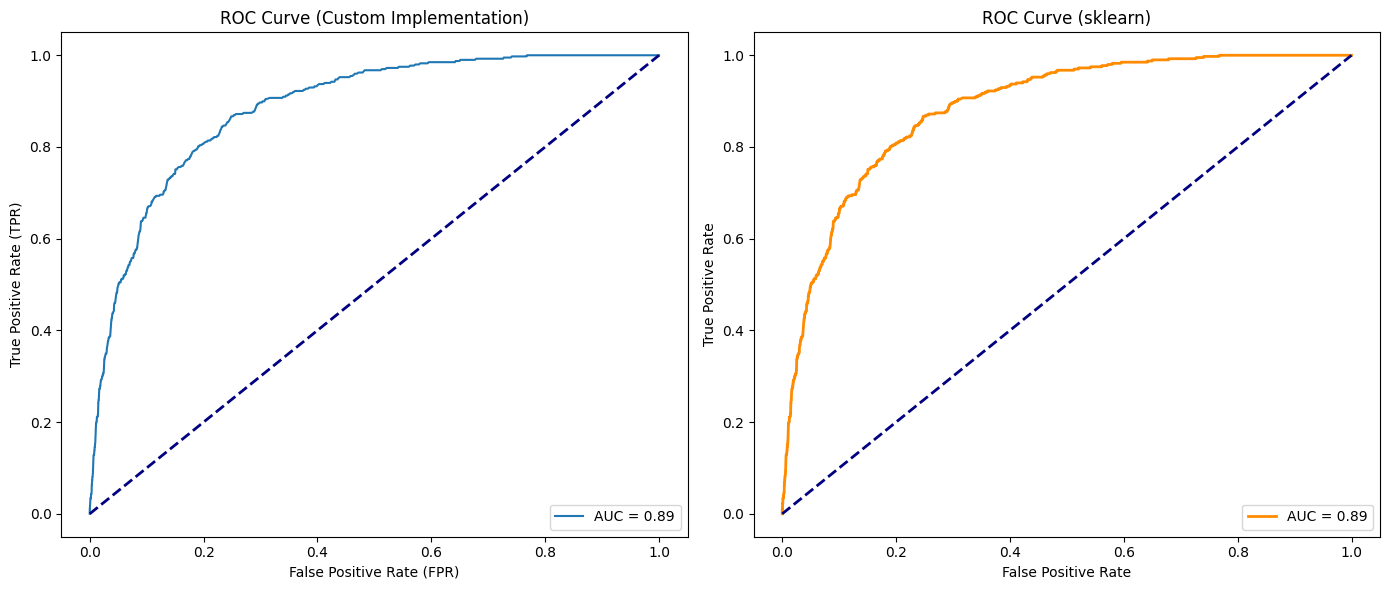

In [193]:
roc_fpr, roc_tpr, thresholds,auc_value = roc_curve_scratch(y_test_class, y_pred)
fpr, tpr, threshold = roc_curve(y_test_class, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(roc_fpr, roc_tpr, label=f'AUC = {auc_value:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve (Custom Implementation)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (sklearn)')
plt.legend(loc='lower right')

plt.savefig('roc_curves.jpg', format='jpg', bbox_inches='tight', pad_inches=0)
plt.tight_layout()
plt.show()
